# Neoway

In [1]:
import sys
sys.path.append('..')
sys.path.append('/anaconda/lib/python3.6/site-packages')
import pandas as pd
import numpy as np
from modules.preprocessing import load_word_embedding_model
from modules.preprocessing import Preprocessing
from modules.preprocessing.generate_labels import gen_labels
from modules.feature_generation.gen_similarities import similarities
from sklearn.model_selection import train_test_split
from modules.preprocessing import Preprocessor
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score
#import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import itertools

## Run on sample data to find best model using grid search

In [2]:
'''
read data
'''
df1 = pd.read_csv('data/companies_data_neoway_subsample/input.csv')
df2 = pd.read_csv('data/companies_data_neoway_subsample/reference.csv')
match_df = pd.read_csv('data/companies_data_neoway_subsample/match.csv')

'''
specify id names
'''
df1_id = 'serial'
df2_id = 'serial'
match_id1 = 'serial_input' #corresponds to df1_id
match_id2 = 'serial_reference' #corresponds to df2_id

'''
train/test split on input dataset
'''
#random split inputs into train/test using original dataset
df1_train, df1_test = train_test_split(df1, test_size=0.33, random_state=42)


#set index dic
df1_train_index = dict(zip(df1_train[df1_id], df1_train.reset_index().index))
df1_test_index = dict(zip(df1_test[df1_id], df1_test.reset_index().index))

'''
id column manipulation
'''
# save for later use to generate labels
df1_train_id_col = df1_train[df1_id]
df1_test_id_col = df1_test[df1_id]
df2_id_col = df2[df2_id]

match_train = match_df[match_df[match_id1].isin(df1_train_id_col)]
match_test = match_df[match_df[match_id1].isin(df1_test_id_col)]

#drop id columns because we don't need to compute id similarity
df1_train = df1_train.drop(columns = [df1_id])
df1_test = df1_test.drop(columns = [df1_id])
df2 = df2.drop(columns = [df2_id])

print('\tdf1 train shape: ', df1_train.shape, '\n',
      '\tmatch train shape: ', match_train.shape, '\n'
      '\tdf1 test shape: ', df1_test.shape, '\n'
      '\tmatch test shape: ', match_test.shape)

	df1 train shape:  (126, 5) 
 	match train shape:  (9, 2) 
	df1 test shape:  (63, 5) 
	match test shape:  (7, 2)


In [3]:
print("***preprocessing***")

processor = Preprocessor(special_columns=['name','addressStreet'],zip_code = "addressZip")
processor.fit(df1_train,df2) #fitting on training dataset for input and on whole dataset for ref

processed_train = processor.transform(df1_train, df2)
processed_test = processor.transform(df1_test, df2)

***preprocessing***
**** df1 divide columns ****
numerical_cols :  ['addressZip']
special_field_cols :  ['name' 'addressStreet' 'addressZip']
word_embedding_cols :  ['name' 'addressStreet' 'addressCity' 'addressState']

 **** df2 divide columns ****
numerical_cols :  ['addressZip']
special_field_cols :  ['name' 'addressStreet' 'addressZip']
word_embedding_cols :  ['name' 'addressStreet' 'addressCity' 'addressState']


/Users/rakshitanagalla/Desktop/capstone-entitymatching/modules/preprocessing/preprocess_special_columns.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[a] = df[a].astype(str)
/Users/rakshitanagalla/Desktop/capstone-entitymatching/modules/preprocessing/preprocess_special_columns.py:109: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return df.astype(str).as_matrix(), None, None
/Users/rakshitanagalla/Desktop/capstone-entitymatching/modules/preprocessing/__init__.py:349: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df1_numeric = df1_numeric.as_matrix().astype(float)
/Users/rakshitanagalla/Desktop/capstone-entitymatching/modules/preprocessing/__init__.py:350: Future

In [4]:
def gen_x(processed_data):

    '''
    get numerical data
    '''

    num_matrix_1, num_matrix_2 = processed_data["numerical"][0],processed_data["numerical"][1]
    embed_matrix_1, embed_matrix_2 = processed_data["word_embedding_fields"][0],processed_data["word_embedding_fields"][1]
    spc_matrix_1, spc_matrix_2 = processed_data["special_fields"][0],processed_data["special_fields"][1]

    '''
    calculate similarities
    '''

    num_sg_data = similarities().numerical_similarity_on_matrix(num_matrix_1,num_matrix_2,method = "scaled_gaussian")
    num_mm_data = similarities().numerical_similarity_on_matrix(num_matrix_1,num_matrix_2,method = "min_max")
    embed_tfidf_data = similarities().vector_similarity_on_matrix(embed_matrix_1,embed_matrix_2)
    #embed_mean_data = similarities().vector_similarity_on_matrix(embed_matrix_1,embed_matrix_2)
    #embed_min_data = similarities().vector_similarity_on_matrix(embed_matrix_1,embed_matrix_2)
    #embed_max_data = similarities().vector_similarity_on_matrix(embed_matrix_1,embed_matrix_2)
    spc_lav_data = similarities().text_similarity_on_matrix(spc_matrix_1,spc_matrix_2, method = "lavenshtein")
    spc_jw_data = similarities().text_similarity_on_matrix(spc_matrix_1, spc_matrix_2, method="jaro_winkler")
    spc_jc_data = similarities().text_similarity_on_matrix(spc_matrix_1, spc_matrix_2, method="jaccard")
    '''
    concatenate all data
    '''
    # only concatenate non-empty similarity matrices
    non_empty = []

    for m in num_sg_data, num_mm_data, embed_tfidf_data, spc_lav_data, spc_jw_data, spc_jc_data:
        if m.size !=0:
            non_empty.append(m)

    x = np.concatenate([i for i in non_empty], axis = 1)

    print(x.shape)

    return x

In [5]:
'''
generate features
'''
x_train = gen_x(processed_train)
x_test = gen_x(processed_test)

(46242, 15)
(23121, 15)


In [6]:
'''
generate labels
'''
# generate y labels
y_train = gen_labels(df1_train_id_col, df2_id_col, match_train, match_id1, match_id2)

# simple check to see if x and y match in size
print (y_train.shape[0] == x_train.shape[0])
print(y_train.sum() == match_train.shape[0])

# generate y labels
y_test = gen_labels(df1_test_id_col, df2_id_col, match_test, match_id1, match_id2)

# simple check to see if x and y match in size
print (y_test.shape[0] == x_test.shape[0])
print(y_test.sum() == match_test.shape[0])

True
True
True
True


In [7]:
'''
Impute
'''
col_means = np.nanmean(x_train,axis=0)
inds_train  = np.where(np.isnan(x_train))
inds_test = np.where(np.isnan(x_test))
x_train[inds_train]=np.take(col_means, inds_train[1])
x_test[inds_test]=np.take(col_means, inds_test[1])

In [8]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import svm
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=3,scoring='f1')
grid_search.fit(x_train, y_train)
grid_search.best_params_

//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

{'C': 10, 'gamma': 0.01}

In [9]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {'max_depth': np.arange(3, 10)}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3,scoring='f1')
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': 7}

RF Sample Test-set Score (Old Definition)
	Precision: 1.000
	Recall: 0.857
	F1: 0.923
	Accuracy: 0.9999567492755503
SVC Sample Test-set Score (Old Definition)
	Precision: 1.000
	Recall: 0.286
	F1: 0.444
	Accuracy: 0.9997837463777518
DT Sample Test-set Score (Old Definition)
	Precision: 1.000
	Recall: 0.429
	F1: 0.600
	Accuracy: 0.9998269971022015


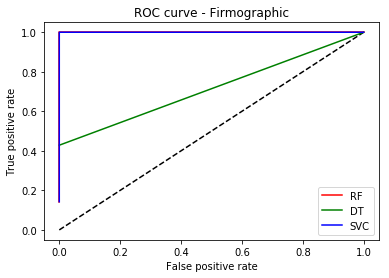

In [10]:
'''
RF
'''
rf_random = RandomForestClassifier(n_estimators=300,
                                    min_samples_split=5,
                                    min_samples_leaf=2,
                                    max_features='sqrt', max_depth=40,
                                    class_weight='balanced',
                                    bootstrap=False, random_state=42, n_jobs=-1)

rf_random.fit(x_train, y_train)
# predict
y_pred_rf = rf_random.predict(x_test)
y_pred_prob_rf = rf_random.predict_proba(x_test)[:, 1]
# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
# precision, recall, f1
print('RF Sample Test-set Score (Old Definition)')
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_test)/len(y_test)))

'''
SVM
'''
svc_random = svm.SVC(kernel='rbf', C=10, gamma=0.01, random_state=42, probability=True)
svc_random.fit(x_train, y_train)
# predict
y_pred_svc = svc_random.predict(x_test)
y_pred_prob_svc = svc_random.predict_proba(x_test)[:, 1]
# roc curve
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_prob_svc)
# precision, recall, f1
print('SVC Sample Test-set Score (Old Definition)')
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_svc))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_svc))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_svc))
print("\tAccuracy: {}".format(sum(y_pred_svc==y_test)/len(y_test)))

'''
DT
'''
dt_random = DecisionTreeClassifier(max_depth=7, random_state=42)

dt_random.fit(x_train, y_train)
# predict
y_pred_dt = dt_random.predict(x_test)
y_pred_prob_dt = dt_random.predict_proba(x_test)[:, 1]
# roc curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)
# precision, recall, f1
print('DT Sample Test-set Score (Old Definition)')
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_dt))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_dt))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_dt))
print("\tAccuracy: {}".format(sum(y_pred_dt==y_test)/len(y_test)))

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, 'r',label='RF')
plt.plot(fpr_dt, tpr_dt, 'g',label='DT')
plt.plot(fpr_svc, tpr_svc, 'b',label='SVC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Firmographic')
plt.legend(loc='best')
plt.show()


In [16]:
def gen_orig_labels(pred_df, true_match_df, df1_id_col, match_id1, df2_id_col, match_id2):
    
    match = true_match_df.dropna()
    match['true_label']=1

    mat = pred_df[pred_df['prob']>0.5]
    pred_match = mat.loc[mat.groupby(match_id1)['prob'].idxmax()]
    pred_match['pred_label']=1

    id_ = pd.DataFrame(df1_id_col)
    id_.columns=[match_id1]

    tmp = pred_match.merge(match, how = 'outer')
    tmp = tmp.merge(id_,how='outer')
    tmp['pred_label'] = tmp['pred_label'].fillna(0).astype(int)
    #tmp = tmp.loc[tmp.groupby(match_id1)['pred_label'].idxmin()]

    tmp['true_label'] = tmp['true_label'].fillna(0).astype(int)
    tmp=tmp.drop(columns=['prob'])
    tmp = tmp.sort_values(by=[match_id1])
        
    return tmp

In [20]:
res =[]
for idx, (id_1,id_2) in enumerate(itertools.product(list(df1_test_id_col), list(df2_id_col))):
    res.append([id_1,id_2,y_pred_prob_rf[idx]])

assert(len(res) == len(y_pred_prob_rf))    
pred_match = pd.DataFrame(res, columns=[match_id1,match_id2,'prob'])

In [21]:
result = gen_orig_labels(pred_match, match_test,df1_test_id_col, match_id1, df2_id_col, match_id2)
true_labels = result['true_label']
pred_labels = result['pred_label']

In [22]:
print('RF Sample Test-set Score -- Aligned with Neoway')

print("\tPrecision: %1.3f" % precision_score(true_labels, pred_labels))
print("\tRecall: %1.3f" % recall_score(true_labels, pred_labels))
print("\tF1: %1.3f" % f1_score(true_labels, pred_labels))
#print("\tAccuracy: {}".format(sum(pred==true)/len(true)))

RF Sample Test-set Score -- Aligned with Neoway
	Precision: 1.000
	Recall: 0.857
	F1: 0.923


## Run best model on sample size of 10,000,000

In [3]:
'''
read data
'''
df1 = pd.read_csv('data/companies_data_neoway/full/input.csv')
df2 = pd.read_csv('data/companies_data_neoway/full/reference.csv')
block = pd.read_csv('company_zipcode_blocked_test_10000000.csv')
block = block.drop_duplicates() #in case there are duplicates in blocked.csv

In [ ]:
'''
TODO: check blocking coverage
'''


In [4]:
'''
specify id names
'''
df1_id = 'serial'
df2_id = 'serial'
match_id1 = 'serial_input' #corresponds to df1_id
match_id2 = 'serial_reference' #corresponds to df2_id


#uncomment this block when sampling on company_zipcode_blocked.csv
block_inputs = block['input_serial'].unique()
df1 = df1[df1[df1_id].isin(block_inputs)]
df1 = df1.reset_index(drop=True)


'''
train/test split on input dataset
'''
#random split inputs into train/test using original dataset
df1_train, df1_test = train_test_split(df1, test_size=0.33, random_state=42)


#set index dic
df1_train_index = dict(zip(df1_train[df1_id], df1_train.reset_index().index))
df1_test_index = dict(zip(df1_test[df1_id], df1_test.reset_index().index))

'''
id column manipulation
'''
# save for later use to generate labels
df1_train_id_col = df1_train[df1_id]
df1_test_id_col = df1_test[df1_id]
df2_id_col = df2[df2_id]

#drop id columns because we don't need to compute id similarity
df1_train = df1_train.drop(columns = [df1_id])
df1_test = df1_test.drop(columns = [df1_id])
df2 = df2.drop(columns = [df2_id])

#also split block into train/test according to df1_train and df1_test
block_train = block[block['input_serial'].isin(df1_train_id_col)]
block_test = block[block['input_serial'].isin(df1_test_id_col)]

In [ ]:
'''
preprocessing
'''
'''
processor = Preprocessor(special_columns=['name','addressStreet'],zip_code='addressZip')
processor.fit(df1_train,df2) #fitting on training dataset for input and on whole dataset for ref
'''

In [ ]:
'''
func to generate feature matrix
'''
'''
def get_feature_matrix(df1,df2,df1_index,block):
    count = 0
    df2_bool = df2_id_col.isin(block['refer_serial'].unique()) #extract only relevant ref data
    df2 = df2[df2_bool]
    df2_index = dict(zip(df2_id_col[df2_bool], df2.reset_index().index)) #set index dic
    processed_data = processor.transform(df1,df2)
    num_matrix_1,num_matrix_2 = processed_data["numerical"][0],processed_data["numerical"][1]
    embed_matrix_1,embed_matrix_2 = processed_data["word_embedding_fields"][0],processed_data["word_embedding_fields"][1]
    spc_matrix_1,spc_matrix_2 = processed_data["special_fields"][0],processed_data["special_fields"][1]
    X = []
    for i, r in block.iterrows():
        row=[]
        df1_i = df1_index[r['input_serial']]
        df2_i = df2_index[r['refer_serial']]
        row+=[similarities().numerical_similarity_on_matrix(num_matrix_1[[df1_i]],num_matrix_2[[df2_i]])]
        row+=[similarities().vector_similarity_on_matrix(embed_matrix_1[[df1_i]],embed_matrix_2[[df2_i]])]
        row+=[similarities().text_similarity_on_matrix(spc_matrix_1[[df1_i]],spc_matrix_2[[df2_i]],method = "lavenshtein")]
        row+=[similarities().text_similarity_on_matrix(spc_matrix_1[[df1_i]],spc_matrix_2[[df2_i]],method = "jaro_winkler")]
        row+=[similarities().text_similarity_on_matrix(spc_matrix_1[[df1_i]],spc_matrix_2[[df2_i]],method = "jaccard")]
        X+=[np.hstack(row)]
        count += 1 #for checking progress
        if count % 100000 == 0:
            print("loop "+str(count))
    
    X = np.vstack(X)
    
    return X
'''

In [ ]:
'''
generate features
'''
'''
x_train = get_feature_matrix(df1_train,df2,df1_train_index,block_train)
print("***x_train done***")
x_test = get_feature_matrix(df1_test,df2,df1_test_index,block_test)
print("***x_test done***")
'''
'''
save features
'''
'''
np.save('neoway_x_train_10000000_blocking',x_train)
#del x_train
print("***x_train saved***")

np.save('neoway_x_test_10000000_blocking',x_test)
#del x_test
print("***x_test saved***")
'''

In [5]:
'''
load features
'''
x_train = np.load('neoway_x_train_10000000_blocking.npy')
x_test = np.load('neoway_x_test_10000000_blocking.npy')

In [7]:
print(x_train.shape)
print(x_test.shape)

(6585145, 14)
(3414854, 14)


In [6]:
'''
generate labels
'''
print('generate labels')
mapping=pd.read_csv('data/companies_data_neoway/full/match.csv')
mapping['label']=1

y_train = pd.merge(block_train,mapping,left_on=['input_serial','refer_serial'],right_on=['serial_input','serial_reference'],how='left')
#y_train = y_train.drop_duplicates() #bc some depulicates in abt_buy_perfectMapping.csv?
y_train = y_train["label"].fillna(0).astype(int)

y_test = pd.merge(block_test,mapping,left_on=['input_serial','refer_serial'],right_on=['serial_input','serial_reference'],how='left')
#y_test = y_test.drop_duplicates() #bc some depulicates in abt_buy_perfectMapping.csv?
y_test = y_test["label"].fillna(0).astype(int)

print(y_train.shape[0] == x_train.shape[0])
print(y_test.shape[0] == x_test.shape[0])

generate labels
True
True


In [8]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 6583872, 1: 1273})
Counter({0: 3414238, 1: 616})


In [7]:
'''
get validation set
'''
x_train_new, x_val, y_train_new, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)
print(sum(y_train_new))
print(sum(y_val))
del x_train
del y_train

1018
255


In [8]:
'''
impute nan's
'''
col_means = np.nanmean(x_train_new,axis=0)
inds_train  = np.where(np.isnan(x_train_new))
inds_val = np.where(np.isnan(x_val))
x_train_new[inds_train]=np.take(col_means, inds_train[1])
x_val[inds_val]=np.take(col_means, inds_val[1])

In [10]:
print("***start modeling***")
rf_random = RandomForestClassifier(n_estimators=300,
                                    min_samples_split=5,
                                    min_samples_leaf=2,
                                    max_features='sqrt', max_depth=40,
                                    class_weight='balanced',
                                    bootstrap=False, random_state=42, n_jobs=-1)

rf_random.fit(x_train_new, y_train_new)
print("training score")
# predict
y_pred_rf = rf_random.predict(x_train_new)
y_pred_prob_rf = rf_random.predict_proba(x_train_new)[:, 1]
# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_train_new, y_pred_prob_rf)
# precision, recall, f1
print('RF')
print("\tPrecision: %1.3f" % precision_score(y_train_new, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_train_new, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_train_new, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_train_new)/len(y_train_new)))
del x_train_new


print("val score")
# predict
y_pred_rf = rf_random.predict(x_val)
y_pred_prob_rf = rf_random.predict_proba(x_val)[:, 1]
# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_prob_rf)
# precision, recall, f1
print('RF')
print("\tPrecision: %1.3f" % precision_score(y_val, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_val, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_val, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_val)/len(y_val)))
del x_val

***start modeling***
training score
RF
	Precision: 0.895
	Recall: 1.000
	F1: 0.945
	Accuracy: 0.9999774112794783
val score
RF
	Precision: 0.891
	Recall: 0.933
	F1: 0.912
	Accuracy: 0.9999650729027227


**not much overfitting, so evaluate on test**

In [102]:
#impute nan's
inds_test = np.where(np.isnan(x_test))
x_test[inds_test]=np.take(col_means, inds_test[1])

#generate labels and pred matrix
y_test = pd.merge(block_test,mapping,left_on=['input_serial','refer_serial'],right_on=['serial_input','serial_reference'],how='left')
pred_match_test = y_test[['input_serial','refer_serial']]
y_test = y_test["label"].fillna(0).astype(int)

print(y_test.shape[0] == x_test.shape[0])

# predict
y_pred_rf = rf_random.predict(x_test)
y_pred_prob_rf = rf_random.predict_proba(x_test)[:, 1]

# update pred matrix
print(y_pred_prob_rf.shape[0] == pred_match_test.shape[0])
pred_match_test['prob'] = y_pred_prob_rf

# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
# precision, recall, f1
print('RF')
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_test)/len(y_test)))

True
True
RF
	Precision: 0.895
	Recall: 0.956
	F1: 0.925
	Accuracy: 0.9999718875243275


In [103]:
print("num of true matches")
print(sum(y_test))

num of true matches
616


In [104]:
print("num of predicted matches")
print(sum(y_pred_rf))

num of predicted matches
658


In [105]:
def gen_orig_labels(pred_df, true_match_df, df1_id_col, match_id1, df2_id_col, match_id2):
    
    match = true_match_df.dropna()
    match.columns = [match_id1, match_id2,'true_label']
    
    #change column names to match w/ "match"
    pred_df.columns = [match_id1, match_id2,'prob']
    mat = pred_df[pred_df['prob']>0.5]
    pred_match = mat.loc[mat.groupby(match_id1)['prob'].idxmax()]
    pred_match['pred_label']=1

    id_ = pd.DataFrame(df1_id_col)
    id_.columns=[match_id1]

    tmp = pred_match.merge(match, how = 'outer')
    tmp = tmp.merge(id_,how='outer')
    tmp['pred_label'] = tmp['pred_label'].fillna(0).astype(int)
    #tmp = tmp.loc[tmp.groupby(match_id1)['pred_label'].idxmin()]

    tmp['true_label'] = tmp['true_label'].fillna(0).astype(int)
    tmp=tmp.drop(columns=['prob'])
    tmp = tmp.sort_values(by=[match_id1])
        
    return tmp

In [106]:
match_test = mapping[mapping[match_id1].isin(df1_test_id_col)]
result = gen_orig_labels(pred_match_test, match_test, df1_test_id_col, match_id1, df2_id_col, match_id2)
true_labels = result['true_label']
pred_labels = result['pred_label']

In [107]:
print('RF Sample Test-set Score -- Aligned with Neoway')

print("\tPrecision: %1.3f" % precision_score(true_labels, pred_labels))
print("\tRecall: %1.3f" % recall_score(true_labels, pred_labels))
print("\tF1: %1.3f" % f1_score(true_labels, pred_labels))
#print("\tAccuracy: {}".format(sum(pred==true)/len(true)))

RF Sample Test-set Score -- Aligned with Neoway
	Precision: 0.964
	Recall: 0.924
	F1: 0.944


## Run best model on full datasets¶

In [24]:
'''
read data
'''
df1 = pd.read_csv('data/companies_data_neoway/full/input.csv')
df2 = pd.read_csv('data/companies_data_neoway/full/reference.csv')
block = pd.read_csv('data/company_zipcode_blocked.csv')
block = block.drop_duplicates() #in case there are duplicates in blocked.csv

'''
specify id names
'''
df1_id = 'serial'
df2_id = 'serial'
match_id1 = 'serial_input' #corresponds to df1_id
match_id2 = 'serial_reference' #corresponds to df2_id

'''
train/test split on input dataset
'''
#random split inputs into train/test using original dataset
df1_train, df1_test = train_test_split(df1, test_size=0.33, random_state=42)


#set index dic
df1_train_index = dict(zip(df1_train[df1_id], df1_train.reset_index().index))
df1_test_index = dict(zip(df1_test[df1_id], df1_test.reset_index().index))

'''
id column manipulation
'''
# save for later use to generate labels
df1_train_id_col = df1_train[df1_id]
df1_test_id_col = df1_test[df1_id]
df2_id_col = df2[df2_id]

#drop id columns because we don't need to compute id similarity
df1_train = df1_train.drop(columns = [df1_id])
df1_test = df1_test.drop(columns = [df1_id])
df2 = df2.drop(columns = [df2_id])

#also split block into train/test according to df1_train and df1_test
block_train = block[block['input_serial'].isin(df1_train_id_col)]
block_test = block[block['input_serial'].isin(df1_test_id_col)]

print('\tdf1 train shape: ', df1_train.shape, '\n',
      '\tmatch train shape: ', match_train.shape, '\n'
      '\tdf1 test shape: ', df1_test.shape, '\n'
      '\tmatch test shape: ', match_test.shape)

	df1 train shape:  (17218, 5) 
 	match train shape:  (9, 2) 
	df1 test shape:  (8481, 5) 
	match test shape:  (7, 2)


In [ ]:
'''
preprocessing
'''
'''
processor = Preprocessor(special_columns=['name','addressStreet'],zip_code='addressZip')
processor.fit(df1_train,df2) #fitting on training dataset for input and on whole dataset for ref
'''

In [ ]:
'''
func to generate feature matrix
'''
'''
def get_feature_matrix(df1,df2,df1_index,block):
    count = 0
    df2_bool = df2_id_col.isin(block['refer_serial'].unique()) #extract only relevant ref data
    df2 = df2[df2_bool]
    df2_index = dict(zip(df2_id_col[df2_bool], df2.reset_index().index)) #set index dic
    processed_data = processor.transform(df1,df2)
    num_matrix_1,num_matrix_2 = processed_data["numerical"][0],processed_data["numerical"][1]
    embed_matrix_1,embed_matrix_2 = processed_data["word_embedding_fields"][0],processed_data["word_embedding_fields"][1]
    spc_matrix_1,spc_matrix_2 = processed_data["special_fields"][0],processed_data["special_fields"][1]
    X = []
    for i, r in block.iterrows():
        row=[]
        df1_i = df1_index[r['input_serial']]
        df2_i = df2_index[r['refer_serial']]
        row+=[similarities().numerical_similarity_on_matrix(num_matrix_1[[df1_i]],num_matrix_2[[df2_i]])]
        row+=[similarities().vector_similarity_on_matrix(embed_matrix_1[[df1_i]],embed_matrix_2[[df2_i]])]
        row+=[similarities().text_similarity_on_matrix(spc_matrix_1[[df1_i]],spc_matrix_2[[df2_i]],method = "lavenshtein")]
        row+=[similarities().text_similarity_on_matrix(spc_matrix_1[[df1_i]],spc_matrix_2[[df2_i]],method = "jaro_winkler")]
        row+=[similarities().text_similarity_on_matrix(spc_matrix_1[[df1_i]],spc_matrix_2[[df2_i]],method = "jaccard")]
        X+=[np.hstack(row)]
        count += 1 #for checking progress
        if count % 100000 == 0:
            print("loop "+str(count))
    
    X = np.vstack(X)
    
    return X
'''

In [ ]:
'''
generate features
'''
'''
x_train = get_feature_matrix(df1_train,df2,df1_train_index,block_train)
print("***x_train done***")
x_test = get_feature_matrix(df1_test,df2,df1_test_index,block_test)
print("***x_test done***")
'''
'''
save features
'''
'''
np.save('neoway_x_train_blocking',x_train)
#del x_train
print("***x_train saved***")

np.save('neoway_x_test_blocking',x_test)
#del x_test
print("***x_test saved***")
'''

In [25]:
'''
load train features
'''
x_train = np.load('neoway_x_train_blocking.npy')
print("***x_train loaded***")

***x_train loaded***


In [26]:
'''
generate labels
'''
print('***generate labels***')
mapping=pd.read_csv('data/companies_data_neoway/full/match.csv')
mapping['label']=1

y_train = pd.merge(block_train,mapping,left_on=['input_serial','refer_serial'],right_on=['serial_input','serial_reference'],how='left')
#y_train = y_train.drop_duplicates() #bc some depulicates in abt_buy_perfectMapping.csv?
y_train = y_train["label"].fillna(0).astype(int)

print(y_train.shape[0] == x_train.shape[0])

***generate labels***
True


In [27]:
'''
get validation set
'''
x_train_new, x_val, y_train_new, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)
print(sum(y_train_new))
print(sum(y_val))
del x_train
del y_train

13114
3279


In [30]:
'''
impute nan's
'''
col_means = np.nanmean(x_train_new,axis=0)
inds_train  = np.where(np.isnan(x_train_new))
inds_val = np.where(np.isnan(x_val))
x_train_new[inds_train]=np.take(col_means, inds_train[1])
x_val[inds_val]=np.take(col_means, inds_val[1])

In [ ]:
print("***start modeling***")
rf_random = RandomForestClassifier(n_estimators=300,
                                    min_samples_split=5,
                                    min_samples_leaf=2,
                                    max_features='sqrt', max_depth=40,
                                    class_weight='balanced',
                                    bootstrap=False, random_state=42, n_jobs=1)

rf_random.fit(x_train_new, y_train_new)
print("training score")
# predict
y_pred_rf = rf_random.predict(x_train_new)
y_pred_prob_rf = rf_random.predict_proba(x_train_new)[:, 1]
# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_train_new, y_pred_prob_rf)
# precision, recall, f1
print('RF')
print("\tPrecision: %1.3f" % precision_score(y_train_new, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_train_new, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_train_new, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_train_new)/len(y_train_new)))
del x_train_new


print("val score")
# predict
y_pred_rf = rf_random.predict(x_val)
y_pred_prob_rf = rf_random.predict_proba(x_val)[:, 1]
# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_prob_rf)
# precision, recall, f1
print('RF')
print("\tPrecision: %1.3f" % precision_score(y_val, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_val, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_val, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_val)/len(y_val)))
del x_val

***start modeling***


**not much overfitting, so evaluate on test**

In [ ]:
x_test = np.load('neoway_x_test_blocking.npy')
print("***x_test loaded***")

#impute nan's
inds_test = np.where(np.isnan(x_test))
x_test[inds_test]=np.take(col_means, inds_test[1])

#generate labels
y_test = pd.merge(block_test,mapping,left_on=['input_serial','refer_serial'],right_on=['serial_input','serial_reference'],how='left')
y_test = y_test["label"].fillna(0).astype(int)

print(y_test.shape[0] == x_test.shape[0])

# predict
y_pred_rf = rf_random.predict(x_test)
y_pred_prob_rf = rf_random.predict_proba(x_test)[:, 1]
# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
# precision, recall, f1
print('RF')
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_test)/len(y_test)))

In [ ]:
# save the classifier
import pickle
with open('neoway_rf_blocking_final.pkl', 'wb') as fid:
    pickle.dump(rf_random, fid, protocol=4)

print("***model saved***")